In [1]:
import numpy as np
import tensorflow as tf
import mplhep
import matplotlib.pyplot as plt
import uproot as up
import os
os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
ZFIT_DISABLE_TF_WARNINGS=1
import zfit
from zfit import z
# Test the modules are being imported correctly

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: numpy.core.multiarray failed to import

In [2]:
import sys
sys.path, sys.version

(['/disk/homedisk/home/user211/project',
  '/usr/lib64/python39.zip',
  '/usr/lib64/python3.9',
  '/usr/lib64/python3.9/lib-dynload',
  '',
  '/home/user211/.local/lib/python3.9/site-packages',
  '/usr/local/lib64/python3.9/site-packages',
  '/usr/local/lib/python3.9/site-packages',
  '/usr/lib64/python3.9/site-packages',
  '/usr/lib/python3.9/site-packages',
  '/usr/lib/python3.9/site-packages/IPython/extensions',
  '/disk/homedisk/home/user211/.ipython'],
 '3.9.5 (default, May 14 2021, 00:00:00) \n[GCC 11.1.1 20210428 (Red Hat 11.1.1-1)]')

In [6]:
obs = zfit.Space('x', limits=(-10, 10))

mu = zfit.Parameter("mu", 2.4, -1, 5)
sigma = zfit.Parameter("sigma", 1.3,  0, 5)

gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

data_np = np.random.normal(0, 1, size=10000)
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [7]:
# Stage 1: create an unbinned likelihood with the given PDF and dataset
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

# Stage 2: instantiate a minimiser (in this case a basic minuit minimizer)
minimizer = zfit.minimize.Minuit()

# Stage 3: minimise the given negative likelihood
result = minimizer.minimize(nll)

# Stage 3: minimise the given negative likelihood but floating only specific parameters (e.g. mu)
#result2 = minimizer.minimize(nll, params=[mu])

In [8]:
# Information on all the parameters in the fit
print(result.params)

# Printing information on specific parameters, e.g. mu
print("mu={}".format(result.params[mu]['value']))

name       value    at limit
------  --------  ----------
mu      0.008846       False
sigma     0.9942       False
mu=0.008846284667640833


In [9]:
print(f"Function minimum: {result.fmin}")
print(f"Converged: {result.converged}")
print(f"Valid: {result.valid}")

Function minimum: -16522.12733878266
Converged: True
Valid: True


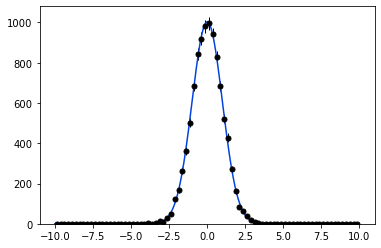

In [13]:
import mplhep

lower, upper = obs.limits
data_np = zfit.run(data.value()[:, 0])

# plot the data as a histogramm
bins = 80
counts, bin_edges = np.histogram(data_np, bins, range=(lower[-1][0], upper[0][0]))
mplhep.histplot((counts, bin_edges), yerr=True, color='black', histtype='errorbar')

# evaluate the func at multiple x and plot
x_plot = np.linspace(lower[-1][0], upper[0][0], num=1000)
y_plot = zfit.run(gauss.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot * data_np.shape[0] / bins * obs.area(), color='xkcd:blue')
plt.show()

